# Homework 05
## Brown University
## DATA 1010
## Fall 2020

## Problem 1

Use the inverse CDF trick to sample from the probability measure whose density function is $f(x) = 2xe^{-x^2} \mathbf{1}_{x \geq 0}$. You can take as given a random number generator which samples from $\mathrm{Uniform}(0, 1)$. Explain your answer mathematically, and confirm that it works empirically by implementing your solution in code.

The cumulative integral of $f$ is 0 up to $x=0$ and then $1 - e^{-x^2}$ thereafter. Therefore, the quantile function is the inverse of $x\mapsto 1 - e^{-x^2}$, namely $u\mapsto \sqrt{-\log(1-u)}$. So we can generate a random variable with the desired distribution by substituting a uniformly sampled random variable $U$ into this expression. 

Let's do this many times and make a histogram of the results, as a way of checking that this works as expected: 

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1278


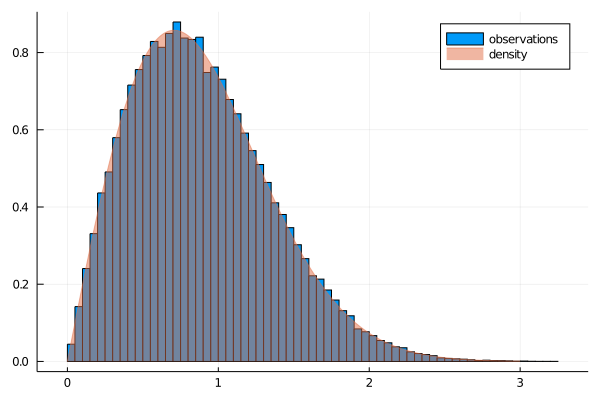

In [1]:
using Plots, Distributions
histogram([sqrt(-log(1-rand(Uniform(0, 1)))) for _ in 1:100_000], label = "observations", normed = true)
plot!(0:0.01:3, x -> 2x*exp(-x^2), fillrange = 0, opacity = 0.5, label = "density")


Checks out.

## Problem 2

In this problem, we'll discover a concrete connection between the probabilistic notion of correlation and the mental picture you might have of correlation which involves a line cutting through some representation of the joint distribution.

*Note: I highly recommend working this one out following the hints rather than trying to look up anything online. Every source I could find does this problem from a statistical point of view, working with $n$ observations, rather than a probabilistic point of view, working directly from the joint distribution. This method is more straightforward and offers more insight, since it shows how the connection does not actually depend on the statistical context.*

Recall that the correlation between two variables is defined by
$$
\rho = \frac{\mathrm{Cov}(X, Y)}{\sigma_X \sigma_Y}. 
$$

(a) Consider two real-valued, non-constant random variables $X$ and $Y$. Find the line in the plane which minimizes the expected squared vertical distance from a point selected from the joint distribution of $X$ and $Y$ to the line. Relate the slope of this line to the correlation $\rho$ and the standard deviations $\sigma_X$ and $\sigma_Y$. 

*Hint 1: Represent the line as $y = mx + b$ and write an expression for the vertical distance from the point $(X,Y)$ to the line. Take the expectation of that expression (which makes sense because $X$ and $Y$ are random variables).* 

*Hint 2: Use your multivariable calculus knowledge to find the values of $m$ and $b$ which minimize this expression. Note that expectations involving $X$ and $Y$ are constant with respect to the optimization over $m$ and $b$. It works out that the resulting system of equations is solvable by hand and only has one solution.*

(b) Verify this on a few random examples of a bivariate Gaussians with nonzero correlation. Plot the density function or mass function as well as the line which minimizes probability-mass-weighted the sum of squared vertical distances to the line.

*Note: You can generate a random positive semidefinite matrix $\Sigma$ by generating a random matrix $A$ and setting $\Sigma = AA'$.*

(c) In part (b), the graph you get might look a bit surprising. Describe what you would need to do with a $2 \times 2$ matrix $\Sigma$ if you wanted to find the directions of the major and minor axes of the ellipses which are the level sets of the multivariate Gaussian with covariance matrix $\Sigma$. 

*Hint: you want to split this problem into two parts: (i) find the major and minor axes of the ellipse obtained by applying the linear transformation $A$ to the unit circle, and (ii) compute an appropriate transformation $A$ so that the desired vector is $AZ + \mu$, where $A$ is a standard multivariate Gaussian. Note that each of these parts were done in class.*

*Solution*. The squared difference from a point to the line is
$$
(Y - mX - b)^2, 
$$
So that average squared difference is the expectation of that quantity. 
Differentiating with respect to $m$, setting the result equal to zero, and applying linearity of expectation, we find that 
$$
2\mathbb{E}[X^2]m + 2\mathbb{E}[X]b = 2\mathbb{E}[XY].
$$
Differentiating with respect to $b$ and setting the result equal to zero, we get 
$$
2\mathbb{E}[X]m + 2b = 2\mathbb{E}[Y]. 
$$

Dividing both equations by $2$ and then multiplying the second equation by $\mathbb{E}[X]$ so we can eliminate $b$, we find that 
$$
((\mathbb{E}[X^2] - \mathbb{E}[X]^2)m = \mathbb{E}[XY] - \mathbb{E}[X]\mathbb{E}[Y], 
$$
which tells us that 
$$
m = \frac{\mathrm{Cov}(X, Y)}{\mathrm{Var}(X)} = \rho \frac{\sigma_Y}{\sigma_X}.
$$
Meanwhile, substituting back into the second equation gives 
$$
b = \mathbb{E}[Y] - \rho\frac{\sigma_Y}{\sigma_X}\mathbb{E}[X].
$$

Let's see how this looks for various randomly selected multivariate normal distributions:

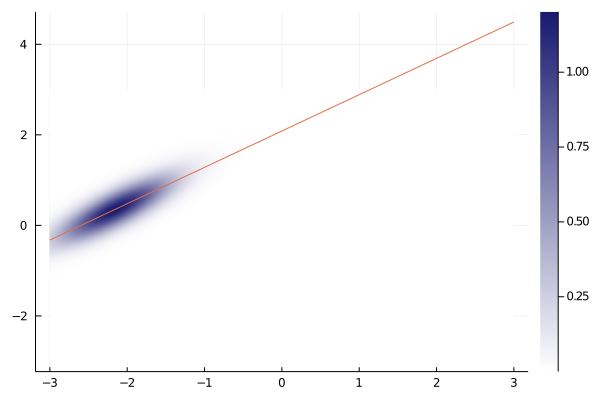

In [2]:
#using Random; Random.seed!(8)
A = randn(2, 2)
Σ = A' * A
μ = randn(2)
m = Σ[1, 2] / Σ[1, 1]
b = μ[2] - m * μ[1]
heatmap(-3:0.01:3, -3:0.01:3, (x,y) -> pdf(MvNormal(μ, Σ), [x, y]), color = cgrad([:white, :MidnightBlue]))
plot!(-3:3, x -> m*x + b, label = "")

It looks a bit strange; we might expect these lines to go straight down the "crest of the ridge", so to speak (in other words, along the major axes of the level sets of the Gaussian density). However, that is a differnet problem to solve. 

We can obtain those axes by writing the multivariate Gaussian as $AZ + \mu$, where $Z$ is a standard multivariate Gaussian and $A = \sqrt{\Sigma}$. Then we can find the singular value decomposition of $A$ and choose the columns of $U$ in that decomposition to identify the major and minor axes of the resulting ellipse. 

To see that this is indeed a different problem, we can work it out both ways for a particular choice of $\Sigma$:

In [3]:
using LinearAlgebra
Σ = [2 0.5; 0.5 1]
σ₁ = √(Σ[1, 1])
σ₂ = √(Σ[2, 2])
ρ = Σ[1, 2] / (σ₁ * σ₂)
A = √Σ
U = svd(A).U
slope_of_major_axis = U[2, 1] / U[1, 1]
slope_of_best_line = ρ * σ₂ / σ₁
slope_of_major_axis, slope_of_best_line

(0.4142135623730951, 0.24999999999999997)

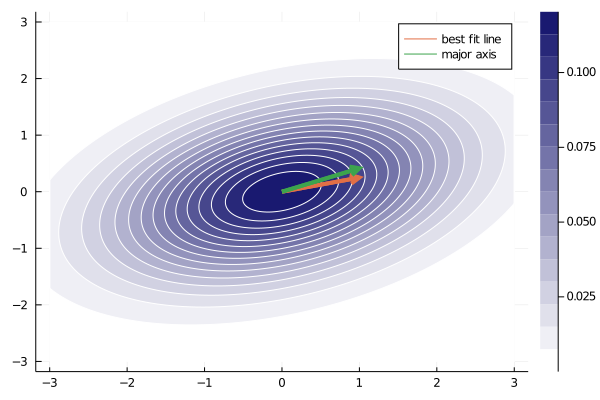

In [4]:
contourf(-3:0.01:3, -3:0.01:3, (x,y) -> pdf(MvNormal([0.0, 0], Σ), [x,y]), color = cgrad(["white", "MidnightBlue"]))
plot!([(0, 0), (1, slope_of_best_line)], label = "best fit line", linewidth = 4, arrow = true)
plot!([(0, 0), (1, slope_of_major_axis)], label = "major axis", linewidth = 4, arrow = true)

# Problem 3 

In class we discussed a connection between the exponential distribution and the gaps between points which are randomly sprinkled on the number line. In this problem, we'll make that more concrete. Let's use the context of calls arriving at a fire department.

(a) Suppose that at each second there's a 1/100 chance of a call arriving that second (suppose for simplicity that calls don't arrive in the same second). How many calls arrive in an hour? Express the answer exactly as a named distribution, and also state another named distribution which approximately describes this random in a way that's more practically useful.

(b) Simulate this experiment many times, and plot a histogram of all of the lengths of the time intervals between calls. For example, if a call arrived at the 10-minute mark, then another at the 20-minute mark, and then another at the 50-minute mark, then the time intervals would be 10 and 30 minutes. 

(c) Consider the random interval between consecutive calls which contains the hour's 30-minute mark. What's the distribution of this random variable? Answer by using a simulation to make a histogram, and answer analytically as well only if you wish. 

(d) Let's change the model. Suppose that there are 36 people who are going to call in that hour, and each one chooses independently from the others, and uniformly at random from the available 3600 seconds, at which second they're going to call. Repeat part (b); do you get noticably different results? Consider musing on why it might make sense that this would be the case.


(a) This is a Binomial distribution with $p = 0.01$ and $n = 3600$. The Normal distribution approximates this to a good extent.

(b)

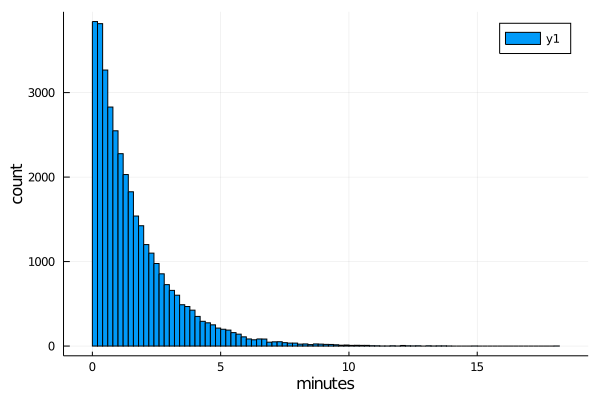

In [5]:
using Plots

function run_ex(n)
    lens = []
    for i in 1:n
        last_call = 0
        for t in 1:3600
            cur = Int(rand() < 0.01)
            if cur == 1
                push!(lens, (t - last_call) / 60)
                last_call = t
            end
        end
    end
    return lens
end

histogram(run_ex(1000), bins=100, xlabel="minutes", ylabel="count")

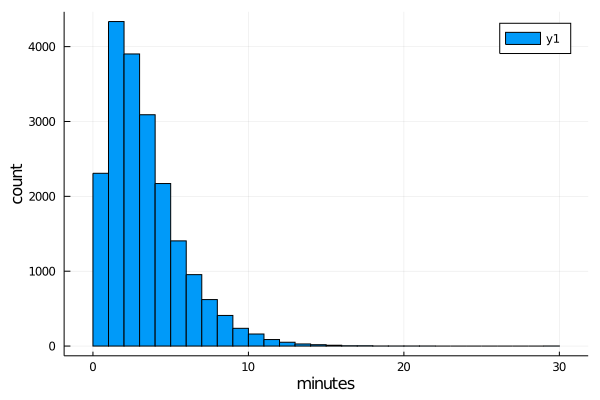

In [6]:
using Plots

function run_30min(n)
    
    lens = []
    for i in 1:n
        last_call = 0
        for t in 1:3600
            cur = Int(rand() < 0.01)
            if cur == 1
                if last_call < 1800 < t
                    push!(lens, (t - last_call) / 60)
                    break
                end
                last_call = t
            end
        end
    end
    return lens
end

histogram(run_30min(20000), bins=50, xlabel="minutes", ylabel="count")


This distribution is $f(k) = k p^2 (1 - p)^{k - 1}$, where $p = \frac{1}{100}$ and $k$ with the unit of seconds.

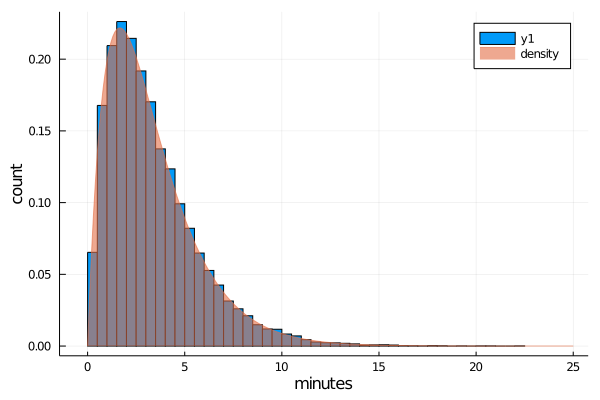

In [7]:
histogram(run_30min(20000), bins=100, xlabel="minutes", ylabel="count", normalize=true)
plot!(0:0.1:25, x -> 0.36 * x * (0.99 ^ (60 * x - 1)), fillrange = 0, opacity = 0.6, label = "density")


(d)

In [8]:
using StatsBase

sample(1:3600, 10, replace=false, ordered=true)

10-element Array{Int64,1}:
   31
   74
  145
  575
 1219
 1495
 1708
 2629
 2877
 3164

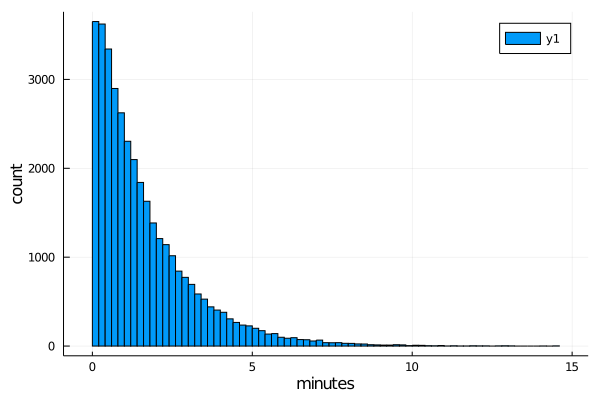

In [9]:

using Plots

function run_ex2(n)
    
    lens = []
    for i in 1:n
        calls = sample(1:3600, 36, replace=false, ordered=true)
        push!(lens, calls[1] / 60)
        for n in 1:(length(calls) - 1)
            push!(lens, (calls[n + 1] - calls[n]) / 60)
        end
    end
    return lens
end

histogram(run_ex2(1000), bins=100, xlabel="minutes", ylabel="count")

The results are not very different. This may seem strange at first, because the set up looks quite different at first glance. However, what's happening is that the number of calls is likely to be fairly close to 36 anyway, so conditioning on it being exactly 36 (which is what we're doing when we sprinkle 36 calls at random in the hour) doesn't make that much difference.

## Problem 4

The integral of a positive-valued function $f$ defined on $[a,b]$ can be defined as the area between the four curves $x = a, x = b, y = 0,$ and $y = f(x)$.

One way of estimating an area is by using random sampling: Suppose we would like to estimate the value of $\int_0^1 x^2 dx$. We sample uniformly at random from the unit square $\{0 \leq x, y \leq 1\}$, and count the proportion of sampled points satisfy the equation $y \leq x^2$. The more observations sampled, the closer this proportion gets to $\int_0^1 x^2 dx$.

(a) Implement the method described above, and compare your results with the mathematical integral value to check that this method is in fact correct. Please explain why this method makes sense.

(b) Using the method above (with a different function), estimate the value of $\pi$.


(a)

In [10]:
function sample_it(n)
    count = 0
    for i in 1:n
        x, y = rand(2)
        if y <= x ^ 2
            count += 1
        end
    end
    return count / n
end
sample_it(100000)

0.3331


The analytical answer to this problem is $\int_0^1 x^2 dx = \frac{1}{3}(1 - 0) = 0.333$, which is pretty close to the result above. This method makes sense because it samples from the unit square, then estimates the probability that a random point lands below the curve $y = x^2$. This probability is proportionate to the ratio of the area under the curve to the area of the unit square, and while the area of a unit square is $1$, this probability is exactly the area under the curve, which is the integral of the curve function.

(b)

Using the unit circle $x^2 + y^2 = 1$ and the semi-circle function $y = \sqrt{1 - x^2}$, we can estimate the ratio of the area of a quarter circle (the part of the circle that is in the first quadrant) to the unit square, this will give us $\frac{\pi}{4}$. Multiplying the result by $4$ will get us the final result.

In [11]:

function sample_pi(n)
    count = 0
    for i in 1:n
        x, y = rand(2)
        if y <= sqrt(1 - x ^ 2)
            count += 1
        end
    end
    return count / n
end
4 * sample_pi(100000)

3.1472


We can see that this is not a bad estimate.

## Problem 5

(a) Simulate $n=1000$ observations from the joint distribution of $X$ and $Y$, given that $X$ is uniform on $[0,1]$ and $Y=2+1.2X+ϵ$, where $ϵ∼\mathbf{N}(0,0.5)$. Record the integrated squared error for the Nadaraya-Watson estimator (with bandwidth selected by *direct* cross-validation, so you're going to minimize the average over all left-out points of the squared error at the left-out point for the leave-one-out regression estimator) and for the line of best fit. 

(b) Do some simulations for a reasonably wide range of values for $n$ and compute the optimal $\lambda$ for each one. Plot the result; is it somewhat reminiscent of the part Stone's theorem which specifies the asymptotic behavior of the optimal $\lambda$ value?

*Note: you'll have to write code for simulating from the joint distribution of $X$ and $Y$ and for the cross-validation, but the other aspects of Nadaraya-Watson estimation you can draw pretty substantially from Data Gymnasia.*

Let's begin by writing code to sample as specified, and also to compute the Nadaraya-Watson estimator:

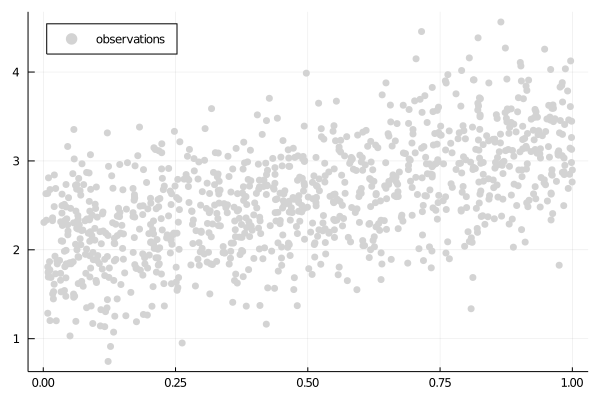

In [12]:
using Optim
using StatsBase

function sample_rand(n)
    X = [rand() for _ in 1:1000]
    Y = 2 .+ (1.2 * X) .+ [rand(Normal(0, 0.5)) for _ in 1:1000]
    return X, Y
end

D(x) = -1 < x < 1 ? 70 / 81 * ((1 - abs(x) ^ 3) ^ 3) : 0
D(x, λ) = 1 / λ * D(x / λ)

r̂(x, λ, X, Y) = (
    sum(yᵢ * Dl(x - xᵢ, λ) for (xᵢ, yᵢ) in zip(X, Y)) / 
    sum(Dl(x - xᵢ, λ) for (xᵢ, yᵢ) in zip(X, Y))
)

X, Y = sample_rand(1000)
scatter(X, Y, label = "observations", color = :lightgray, msw = 0, leg = :topleft)

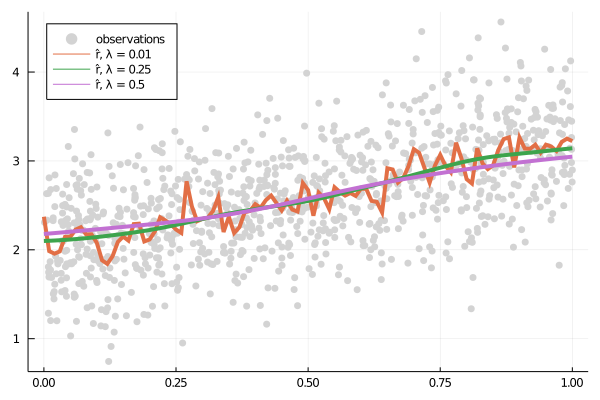

In [13]:
for λ in [0.01, 0.25, 0.5]
    plot!(0:0.01:1, x -> r̂(x, λ, X, Y), label = "r̂, λ = $λ", linewidth = 4)
end
current()

In [14]:
r̂(x, λ, X, Y, j) = (
    sum(yᵢ * D(x - xᵢ, λ) for (i, (xᵢ, yᵢ)) in enumerate(zip(X, Y)) if i ≠ j) / 
    sum(D(x - xᵢ, λ) for (i, (xᵢ, yᵢ)) in enumerate(zip(X, Y)) if i ≠ j)
)

r̂ (generic function with 2 methods)

Here's a manipulative for experimenting with the leave-one-out estimator:

In [15]:
using Interact
@manipulate for j in 1:10
    scatter(X, Y, color = :lightgray, legend = false)
    plot!(xs, x -> r̂(x, 0.01, X, Y, j), ylims = (0, 3.5), linewidth = 4)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["j"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 10,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
5, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/sswatson/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/sswatson/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/sswatson/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/Users/sswatson/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/Users/sswatson/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000001305518d0, Task (runnable) @0x00000001305518d0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"1222926624821086975\",\"id\":\"3276045131580297352\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\

Now let's define the loss associated with each $\lambda$, namely the average squared deviation between each $y$ observation and the $\hat r$ value of the corrsponding $x$ obervation: 

In [16]:
loss(λ, X, Y) = mean((r̂(X[i], λ, X, Y, i) - Y[i])^2 for i in 1:length(X))

loss (generic function with 2 methods)

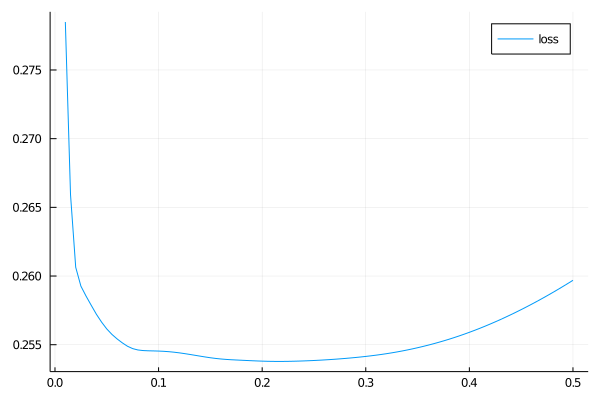

In [17]:
λs = 0.01:0.005:0.5
losses = [loss(λ, X, Y) for λ in λs]
plot(λs, losses, label = "loss")

We can see that the loss value is minimized around 0.1. Let's look there:

In [18]:
o = optimize(λ -> loss(λ, X, Y), 0.05, 0.15)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.050000, 0.150000]
 * Minimizer: 1.500000e-01
 * Minimum: 2.540511e-01
 * Iterations: 35
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 36

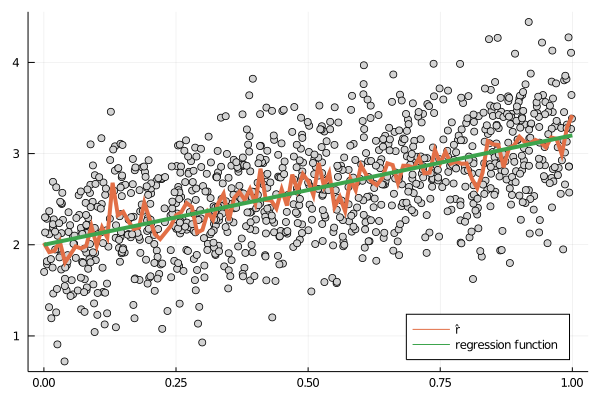

In [19]:
λ_best = Optim.minimizer(o)
scatter(X, Y, color = :lightgray, label = "")
plot!(xs, x -> r̂(x, 0.01, X, Y, j), linewidth = 4, label = "r̂")
plot!(xs, x -> 2 + 1.2*x, linewidth = 4, leg = :bottomright, label = "regression function")

Let's estimate the average squared error for the two estimators by summing over all 100 points:

In [20]:
mean([(r̂(x, λ_best, X, Y) - y)^2 for (x,y) in zip(X, Y)])

0.2318664799375082

In [21]:
mean([(y - (2 + 1.2*x))^2 for (x,y) in zip(X, Y)])

0.23448883725808856

We can see that the values are quite close. In fact, they're so close that we can't even tell from this probabilistic estimate that the mean squared error is actually slightly smaller for the line than for the Nadaraya-Watson estimator. We know it must be, since the regression function is the function which minimizes the mean squared error.

(b) Now let's look at how $\lambda$ relates to $n$. The best $\lambda$ turns out to be quite noisy, so we'll take an average over several runs to smooth things out a bit.

In [22]:
ns = Float64[]
λs = Float64[]
for n in 2 .^ (1:10)
    push!(ns, n)
    λ = mean(begin 
        X, Y = sample_rand(n)
        Optim.minimizer(optimize(λ -> loss(λ, X, Y), 1e-3, 0.5))
    end for _ in 1:100)
    push!(λs, λ)
end

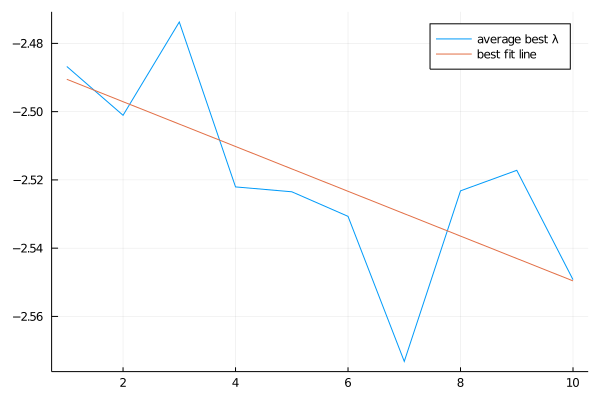

In [23]:
plot(log2.(ns), log2.(λs), label = "average best λ")
a, b = [ones(length(ns)) log2.(ns)] \ log2.(λs)
plot!(log2.(ns), x -> a + b*x, label = "best fit line")

The slope is much smaller in absolute value than $-1/5$, suggesting that the optimal bandwidth either does not obey the $n^{-1/5}$ law when optimized in this way, or that the asypmtotic behavior only becomes apparent for values of $n$ larger than the ones we assessed here: 

In [24]:
a, b

(-2.4839610277507047, -0.006563172735565769)